# Exploring Overlapping Census Boundaries

Evaluating the implications of TELs for debt activity at the local level requires some notion of the demographic characteristics of the jurisdictions in question.  This raises an operational problem.  The debt activity occurs at multiple levels of government, perhaps most often at the municipal or special district level.  By contrast, socioeconomic data is generally collected in detail at the county level (or larger).  Some method of allocating socioeconomic information to smaller jurisdictions must be derived to provide enough information for legit statistical specifications.

The question of how to allocate this information has non-trivial implications for the analysis that it facilitates.  I have [previously proposed](http://gis.stackexchange.com/questions/157610/harmonizing-data-across-geographic-scopes-layers) some rough adjustment mechanisms, but they generally rely on strong assumptions about the spatial distribution of people within a given jurisdiction.  Fortunately, as Dan has pointed out, the [Missouri Census Data Center](http://mcdc.missouri.edu/) (MCDC) has developed a [tool](http://mcdc.missouri.edu/websas/geocorr12.html) that offers a far more robust solution.  Instead of relying assumptions of uniform distributions of people, the tool aggregates up from the block level to provide information on the extent of the overlap across Census geographies.  This approach allows us to retain information that blunt assumptions would discard.  The following description of the tool's capability is taken directly from [MCDC's docs](http://mcdc.missouri.edu/websas/geocorr90_htmls/geocorr.help.html):

>*The MABLE/Geocorr geographic correspondence engine generates files and/or reports showing the relationships between a wide variety of geographic coverages for the United States. It can, for example, tell you with which county or counties each ZIP code in the state of California shares population. It can tell you, for each of those ZIP/county intersections, what the size of that intersection is (based on 1990 population or other user-specifed variable) and what portion of the ZIP's total population is in that intersection. The application permits the user to specify the geographic scope of the correspondence files (typically, one or more complete states, but with the ability to specify counties, cities, or metropolitan areas within those states), and, of course, the specific geographic coverages to be processed. The latter include virtually all geographic units reported in the 1990 U.S. census summary files, and several special "extension coverages" such as 103rd Congress districts, PUMA areas used in the 1990 PUMS files, Labor Market and Commuting Zone areas, and even hydrolgical unit codes (watersheds.) The application creates a report file and a comma-delimited ascii file (by default) which the user can then browse and/or save to their local disk.*

It's difficult to overstate how damn useful this is.  In any event, I've taken the liberty of grabbing a [run](http://mcdc.missouri.edu/tmpscratch/22AUG0900580.geocorr12/geocorr12.csv) from the tool that captures overlap between Census places and counties for all states in the country.  In this Notebook, we will explore these overlaps.  Even with this information, we will still be faced with discretionary choices about how to allocate socioeconomic information that is not countable.  Rather, it is reported statistically, and we clearly have no access to the underlying microdata (think distributions of income or political affiliation, industrial mixtures, etc.).  Any decisions we make on this front will create bias, and the magnitude of this bias will be a function of the extent to which Census places do not nest well into Census counties.  Consequently, this Notebook seeks to develop a method for thinking about this discord.  Note that we may very well decide that Census places are not the appropriate unit of analysis.  The method developed here, however, should be applicable to other geographic combinations.

In [3]:
#Basic data manipulation
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

#Spatial I/O
import fiona

#Spatial Geometry Manipulation
from shapely.geometry import shape,LineString,Polygon,MultiPolygon
from shapely.ops import unary_union
from descartes import PolygonPatch
from rtree import index

#Visualization
from matplotlib.collections import PatchCollection
from mpltools import color
import seaborn as sb

%pylab inline

plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.linewidth']=.5
plt.rcParams['grid.color']='#CBCBCC'
plt.rcParams['patch.facecolor']=(0.8,0.,0.)
plt.rcParams['patch.edgecolor']='w'
plt.rcParams['patch.linewidth']=1.

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Data Input

I am not sure how persistent the [link to our MABLE run](http://mcdc.missouri.edu/tmpscratch/22AUG0900580.geocorr12/geocorr12.csv) is, so the [data are housed in this repository](https://github.com/choct155/TELs_debt/blob/master/geocorr12.csv) as well.  Note that a slight modification has been made.  The initial data had two header rows.  The second one was just a more descriptive version of the first, and it was creating issues with the input parser, so it has been jettisoned.

In [4]:
#Read in data
mcdc=pd.read_csv('geocorr12.csv')

print mcdc.info()

mcdc.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33407 entries, 0 to 33406
Data columns (total 11 columns):
state       33407 non-null int64
placefp     33407 non-null int64
county      33407 non-null int64
stab        33407 non-null object
cntyname    33407 non-null object
placenm     33407 non-null object
intptlon    33407 non-null float64
intptlat    33407 non-null float64
pop10       33407 non-null int64
afact       33407 non-null float64
AFACT2      33407 non-null float64
dtypes: float64(4), int64(4), object(3)
memory usage: 3.1+ MB
None


,state,placefp,county,stab,cntyname,placenm,intptlon,intptlat,pop10,afact,AFACT2
0,1,100,1017,AL,Chambers AL,"Abanda CDP, AL",-85.526890,33.093251,192,1,0.005612
1,1,124,1067,AL,Henry AL,"Abbeville city, AL",-85.251914,31.562700,2688,1,0.155358
2,1,460,1073,AL,Jefferson AL,"Adamsville city, AL",-86.956729,33.593552,4522,1,0.006867
3,1,484,1133,AL,Winston AL,"Addison town, AL",-87.178121,34.201511,758,1,0.030959
4,1,676,1065,AL,Hale AL,"Akron town, AL",-87.742279,32.876794,356,1,0.022589


Some explanation is in order here. The `state`, `placefp`, `county` variables capture [FIPS](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standards) codes for each Census geography, and they correspond to the descriptive names in `stab`, `placenm`, and `cntyname`, respectively.  The longitude and latitude information in `intptlon` and `intptlat` identify the centroid of each Census place (just place hereafter) in most cases.  If the geometry of the place is such that the centroid lies outside of place boundaries, the centroid is moved to the nearest boundary point.  

The last three variables contain the real meat. `pop10` does not capture the entire population of the place, but rather *the population in the intersection*.  Observe three split places in Alabama: Altoona Town, Arab City, and Argo Town.

In [5]:
mcdc[mcdc['afact']<1].head(6)

,state,placefp,county,stab,cntyname,placenm,intptlon,intptlat,pop10,afact,AFACT2
11,1,1660,1009,AL,Blount AL,"Altoona town, AL",-86.342771,34.022778,30,0.032154,0.000523
12,1,1660,1055,AL,Etowah AL,"Altoona town, AL",-86.322138,34.030113,903,0.967845,0.008647
16,1,2116,1043,AL,Cullman AL,"Arab city, AL",-86.503964,34.298482,27,0.003354,0.000336
17,1,2116,1095,AL,Marshall AL,"Arab city, AL",-86.498783,34.328208,8023,0.996646,0.086251
19,1,2320,1073,AL,Jefferson AL,"Argo town, AL",-86.527963,33.710423,61,0.014984,0.000093
20,1,2320,1115,AL,St. Clair AL,"Argo town, AL",-86.504219,33.697150,4010,0.985016,0.047971


Altoona is split by the border between Blount and Etowah counties, though most of it resides in Etowah.  The total population of Altoona is 933.  Likewise, the populations of Arab City and Argo Town are 8050 and 4071, respectively.  Since we have used population to define the overlap, these numbers correspond directly to the allocation factor values stored in the `afact` variable.  Approximately 97% of Altoona's population is contained by Etowah County.  The second allocation factor (`AFACT2`) tells us the proportion of the county population that resides in a given place.  So, 0.8% of Etowah County residents live in Altoona Town.

## What is the Scale of Overlap?

A natural starting place would be to determine how often county boundaries actually split places.  We can answer this question easily, because wholly contained places can be identified by `afact==1`.  How many places have we captured, and how many are wholly contained?

In [6]:
#Capture counts of places and proportion of wholly contained
num_places=len(set(mcdc['placenm']))
num_wc_places=len(set(mcdc[mcdc['afact']==1]['placenm']))
prop_wc_places=num_wc_places/float(num_places)

print 'Number of places:',num_places
print 'Number of wholly contained places:',num_wc_places
print 'Proportion of wholly contained places:',prop_wc_places

Number of places: 29180
Number of wholly contained places: 28167
Proportion of wholly contained places: 0.965284441398


It is encouraging to see that places are split only about 3.5% of the time.  How large is the affected population?

In [7]:
#Capture total pop, wholly contained pop, and the proportion
total_pop=mcdc['pop10'].sum()
wc_pop=mcdc[mcdc['afact']==1]['pop10'].sum()
wc_pop_prop=wc_pop/float(total_pop)

print 'Estimated total population:',total_pop
print 'Population of wholly contained places:',wc_pop
print 'Wholly contained population proportion:',wc_pop_prop

Estimated total population: 308745538
Population of wholly contained places: 196411745
Wholly contained population proportion: 0.636160594489


It is decidedly less encouraging to see that the 3.5% of places account for 36.4% of the population.  It appears the choices we make will be meaningful.

## How Might We Apportion Uncountable Data?

How should distributional information be combined for places split by county borders?  There are at least three approaches that may be taken:

1. *Apply the characteristics of the county housing the largest portion of the place.*  In our small example above from Alabama we see that while those three towns are split, each has 96.7% or more of their population in one county.  Conceivably, we could just write the rest off as rounding error.  Alternatively, one could argue that within place continuity is likely to be a more dominant factor than the broader characteristics of the county that contains only a small percentage of the place.  Of course, this gets to be problematic if a place is more evenly divided, and worse still if more than two counties are involved.
2. *Apply the population-weighted average of the distributions for all involved counties.*  This approach explicitly includes effects from all involved counties.  The argument could be made that even if the county containing only a very small portion of the place has little effect, the low weight will enforce its irrelevance.  This approach does some work to mitigate concerns over fairly even splits.
3. *Don't apportion at all and use the intersections as the unit of analysis.*  This seems to be generally a bad approach, insofar as it disrupts jurisdictional scope for fiscal decisionmaking by relevant officials.  For the sake of argument, however, it would eliminate the need to apportion distributional information at all.  We could just use the information as is.

Let's examine the first two options in greater detail.

### Option 1: Plurality

In the plurality approach, the big weakness is the potential for relatively even splits.  How often does this actually happen?

In [8]:
#plt.rcParams

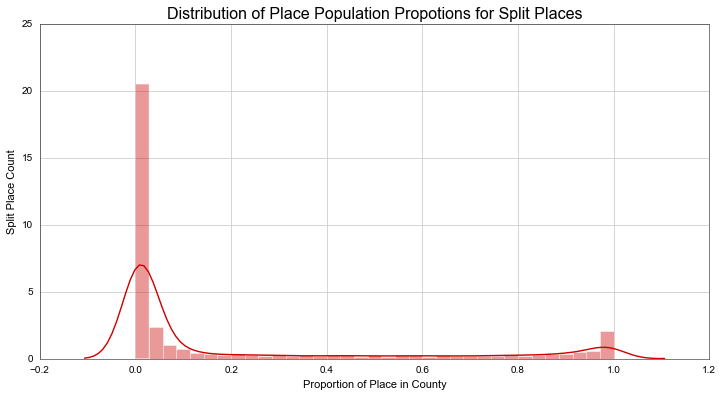

In [9]:
#Capture splits
splits=mcdc[mcdc['afact']!=1]

#Generate plot object
fig,ax=plt.subplots(figsize=(12,6))

#Plot distribution of place population proportions (afact)
sb.distplot(splits['afact'],ax=ax,color='#CC0000')

#Fix labels
ax.set_title('Distribution of Place Population Propotions for Split Places',fontsize=16)
ax.set_xlabel('Proportion of Place in County')
ax.set_ylabel('Split Place Count');

Interesting, those even splits look quite low.  What happens if we weight by population?  

/home/choct155/analysis/Anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


afact_bin
(0, 0.1]      72557687
(0.1, 0.2]     8154341
(0.2, 0.3]     5738820
(0.3, 0.4]     3399484
(0.4, 0.5]      398822
(0.5, 0.6]      746048
(0.6, 0.7]      970756
(0.7, 0.8]     1071665
(0.8, 0.9]     2238492
(0.9, 1]      17057678
Name: pop10, dtype: int64

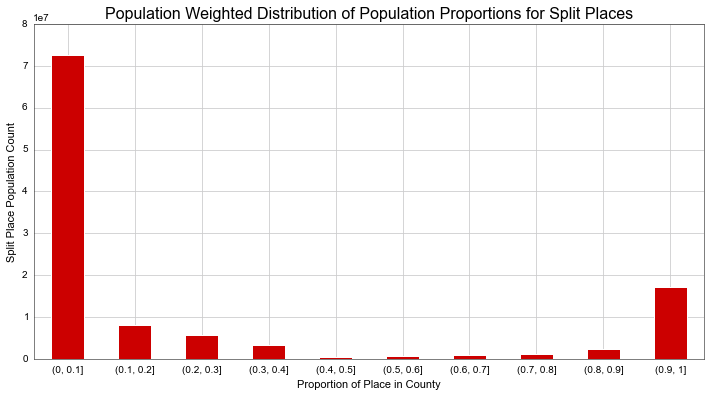

In [10]:
#Bin population proportions
splits['afact_bin']=pd.cut(splits['afact'],list(np.linspace(0,1,11)))

#Capture population counts by afact_bin
split_bin=splits.groupby('afact_bin').sum()['pop10']

#Generate plot object
fig,ax=plt.subplots(figsize=(12,6))

#Plot the weighted distribution
split_bin.plot(kind='bar',ax=ax,color='#CC0000')

#Fix labels
ax.set_title('Population Weighted Distribution of Population Proportions for Split Places',fontsize=16)
ax.set_xlabel('Proportion of Place in County')
ax.set_ylabel('Split Place Population Count')
ax.set_xticklabels([item.get_text() for item in ax.get_xticklabels()],rotation=0)

split_bin

So, even population weighted, we still have a very bimodal split distribution.  This suggests that if we were to go the plurality way, the costs may be fairly contained.

### Option 2: Weighted Average

The challenge in combining distributional information extends from lack of knowledge about the underlying data.  The extent to which this creates a problem decreases as data resolution increases.  Said differently, we can get better precision in a distribution mix as the number of bins increases.  If we had only one data point per county, say median age, we don't know enough about the shapes of the distribution to combine two county median ages into one median age for the split place.  The assumptions required for such an estimate would be generally stronger than that which is required with additional distributional guideposts.  Those guideposts provide information on the potential range in marginal changes associated with moving the median to an "adjacent" member of the population.  For example, without other distributional guideposts, we could not tell the difference between the following populations...

In [11]:
#Define populations
pop1=[1]*4+[5]+[9]*4
pop2=range(1,10)
print 'POP 1: ',pop1
print 'POP 2: ',pop2

POP 1:  [1, 1, 1, 1, 5, 9, 9, 9, 9]
POP 2:  [1, 2, 3, 4, 5, 6, 7, 8, 9]


Additional information puts boundaries on the volatility in the median.

In [12]:
DataFrame(Series(pop1).describe(),columns=['POP1']).join(DataFrame(Series(pop2).describe(),columns=['POP2']))

,POP1,POP2
count,9,9.000000
mean,5,5.000000
std,4,2.738613
min,1,1.000000
25%,1,3.000000
50%,5,5.000000
75%,9,7.000000
max,9,9.000000


In some cases, we do have distributional milestones.  Suppose we had five age buckets:

`< 20, 20-40, 40-60, 60-80, 80+`

Let us generate two age distributions from different data generating processes: normal and uniform.  We want these age distributions to have a couple key properties.  First, all ages must be non-zero.  Second, we are going to cap ages at 100.  To achieve this, we will employ a normalization scheme, which differs across distributions.  For the normal distribution, we can have negative numbers in a random draw, so the negation of the minimum value will serve as an offset to ensure positive reals.  Second, the figures will be divided by the realized range (maximum less minimum value) and multiplied by 100.  In the uniform distribution, we are already guaranteed positive reals, so the first operation is not required.

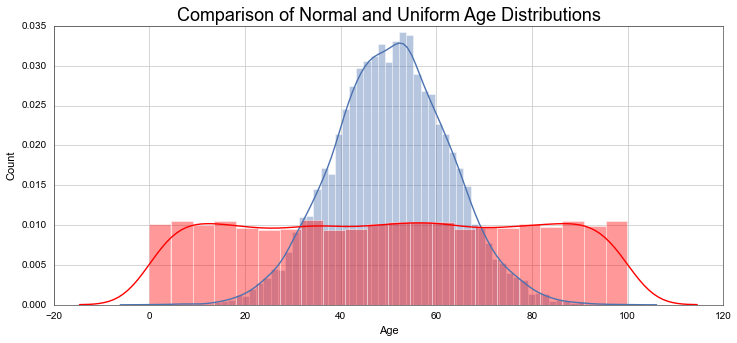

In [22]:
def pop_gen(pop1,pop2):
    #Generate to random age distributions
    npop=np.random.normal(size=10000)
    upop=np.random.uniform(size=10000)

    #Scale the normal ages to be non-positive and range from 0 to 100
    ##Non-negative offset
    npop_min=npop.min()
    npop=npop-npop_min
    ##Normalization to [0,1]
    npop/=npop.max()
    ##Scale to 100
    npop*=100

    #Scale the lognormal ages to range from 0 to 100
    ##Scale to 100
    upop*=100
    
    return (npop,upop)

#Capture populations
pops=pop_gen(10000,10000)

#Generate plot object
fig,ax=plt.subplots(figsize=(12,5))

#Plot age distributions
sb.distplot(pops[0],ax=ax)
sb.distplot(pops[1],ax=ax,color='r')

#Fix labels
ax.set_title('Comparison of Normal and Uniform Age Distributions',fontsize=18)
ax.set_xlabel('Age')
ax.set_ylabel('Count');

Ok, let's look at these guys in buckets and see if our intuition on the merging procedure is correct.  I was going to show this graphically, but it probably suffices to say that as long as we know the bin thresholds and counts (and the bin thresholds are the same across place/county intersections), we can just add all these together to figure out the composite.  However, we will generally not know the distribution that is specific to the intersection, so we will assume a constant distribution across the county.  

What happens if one county holds ten times the population of the other?

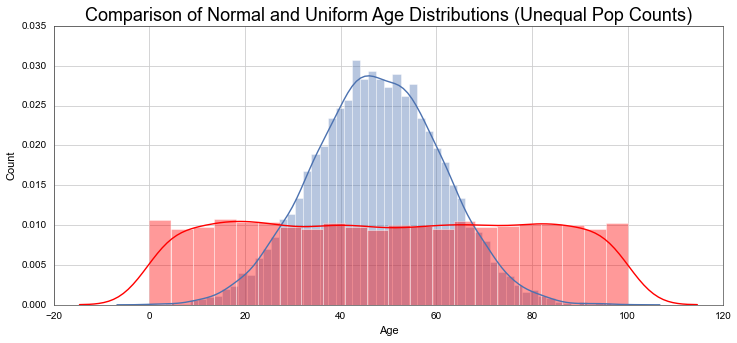

In [23]:
#Capture populations
pops=pop_gen(10000,1000)

#Generate plot object
fig,ax=plt.subplots(figsize=(12,5))

#Plot age distributions
sb.distplot(pops[0],ax=ax)
sb.distplot(pops[1],ax=ax,color='r')

#Fix labels
ax.set_title('Comparison of Normal and Uniform Age Distributions (Unequal Pop Counts)',fontsize=18)
ax.set_xlabel('Age')
ax.set_ylabel('Count');

The density does not change, so we still follow the regular addition by bin procedure

## Spatial Distribution of Splits